In [223]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
import scipy as sp
import nltk
import seaborn as sns
from nltk.corpus import stopwords
import re #regular expressions
from bs4 import BeautifulSoup
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('stopwords')
pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_colwidth',150)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alechantson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [226]:
dataset = pd.read_csv('Cybetrolls.csv')
dataset.head()

,annotation,content
0,1,Get fucking real dude.
1,1,She is as dirty as they come and that crook Rengel the Dems are so fucking corrupt it's a joke. Make Republicans look like ...
2,1,why did you fuck it up. I could do it all day too. Let's do it when you have an hour. Ping me later to sched writing a book here.
3,1,Dude they dont finish enclosing the fucking showers. I hate half assed jobs. Whats the reasononing behind it? Makes no sense.
4,1,WTF are you talking about Men? No men thats not a menage that's just gay.


<AxesSubplot:xlabel='annotation', ylabel='count'>

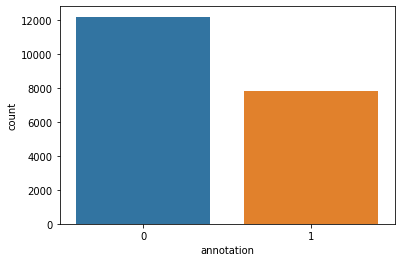

In [227]:
# Check balancedness, more non trolls than non trolls
sns.countplot(x='annotation',data=dataset)

In [228]:
# Text preprocessing
def text_preprocessing(text, language, minWordSize):
    # remove html
    text_no_html = BeautifulSoup(str(text),"html.parser" ).get_text()
    # remove non-letters
    text_alpha_chars = re.sub("[^a-zA-Z']", " ", str(text_no_html)) 
    # convert to lower-case
    text_lower = text_alpha_chars.lower()
    # remove stop words
    stops = set(stopwords.words(language)) 
    text_no_stop_words = ' '
    for w in text_lower.split():
        if w not in stops:  
            text_no_stop_words = text_no_stop_words + w + ' '
    # do stemming
    text_stemmer = ' '
    stemmer = SnowballStemmer(language)
    for w in text_no_stop_words.split():
        text_stemmer = text_stemmer + stemmer.stem(w) + ' ' 
    # remove short words
    text_no_short_words = ' '
    for w in text_stemmer.split(): 
        if len(w) >=minWordSize:
            text_no_short_words = text_no_short_words + w + ' '
    return text_no_short_words


In [229]:
language = 'english'
minWordLength = 2 
dataset['content']=dataset['content'].apply(text_preprocessing, args=(language,minWordLength))

/usr/local/lib/python3.9/site-packages/bs4/__init__.py:417: MarkupResemblesLocatorWarning: "http://tinyurl.com/these-hats-are-damn-tradition" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [230]:
#add length of sentence as feature
dataset['length']  = dataset['content'].str.split().apply(len)

In [231]:
train, test = train_test_split(dataset, test_size=0.20, random_state=0)

In [232]:
#Augmentation to alter the oversampled data
aug_random = naw.RandomWordAug(action="swap")
aug = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased', action="insert")
def augmentator(text):
    text = aug.augment(text) #random insert words that fit in context
    text = aug_random.augment(text) #random switch text
    return text


In [233]:
#Custom oversample
#Setup
max_category_count=0
max_category_count= max(train['annotation'].value_counts())
minority_class=train['annotation'].value_counts()[1:].index.tolist()[0]
#loop through every category
count=len(train[train['annotation']==minority_class])
up_value=50
difference= max_category_count - count
while difference>50:
    print(difference)
    #Oversample and augmentation
    oversample_set= train[train['annotation']==minority_class].sample(int(up_value))
    oversample_set['content']=oversample_set['content'].apply(augmentator)
    difference= difference-len(oversample_set)
    train=train.append(oversample_set, ignore_index = True)

3500
3450
3400
3350
3300
3250
3200
3150
3100
3050
3000
2950
2900
2850
2800
2750
2700
2650
2600
2550
2500
2450
2400
2350
2300
2250
2200
2150
2100
2050
2000
1950
1900
1850
1800
1750
1700
1650
1600
1550
1500
1450
1400
1350
1300
1250
1200
1150
1100
1050
1000
950
900
850
800
750
700
650
600
550
500
450
400
350
300
250
200
150
100


<AxesSubplot:xlabel='annotation', ylabel='count'>

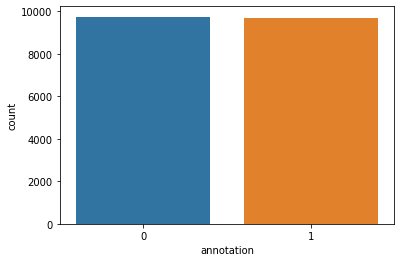

In [234]:
sns.countplot(x='annotation',data=train)
#Data is now balanced

In [235]:
X_train = train.drop(['annotation'], axis=1)
y_train = train['annotation'].values
X_test = test.drop(['annotation'], axis=1)
y_test = test['annotation'].values

In [236]:
# Bag of words with count of every word
def make_bow(X_train,X_test):
    count_vect = CountVectorizer()
    X_train_bag_of_words = count_vect.fit(X_train['content'])
    X_train_bag_of_words = count_vect.transform(X_train['content'])
    X_test_bag_of_words = count_vect.transform(X_test['content'])
    #print(X_train_bag_of_words)
    #print(X_test_bag_of_words)
    
    tfidf_transformer = TfidfTransformer()
    tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_bag_of_words)
    X_train_tf = tf_transformer.transform(X_train_bag_of_words)
    X_test_tf = tf_transformer.transform(X_test_bag_of_words)
    return X_train_tf,X_test_tf,count_vect

In [237]:
X_train_tf,X_test_tf,count_vect=make_bow(X_train,X_test)

In [238]:
#Add lenght and BOW
matrix_train=sp.sparse.csr_matrix(X_train['length'].values)
matrix_train=np.transpose(matrix_train)

matrix_test=sp.sparse.csr_matrix(X_test['length'].values)
matrix_test=np.transpose(matrix_test)

X_train_tf=sp.sparse.hstack((X_train_tf,matrix_train))
X_test_tf=sp.sparse.hstack((X_test_tf,matrix_test))

In [225]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint 
from scipy.stats import uniform
#MODEL
model = MultinomialNB()
parameters = {'alpha':uniform(0.001, 1)}

n_iter_search = 100
random_search = RandomizedSearchCV(model, param_distributions=parameters,cv=100,n_iter=n_iter_search,n_jobs = 6,verbose=5)

random_search = random_search.fit(X_train_tf, y_train)

best_accuracy = random_search.best_score_ 
best_parameters = random_search.best_params_  

print('Best accuracy : ', random_search.best_score_)
print('Best parameters :',random_search.best_params_  )

y_pred = random_search.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100)

#Our models suffers from the bias, naive bayes doesn't have the options to use class weights.

Fitting 100 folds for each of 100 candidates, totalling 10000 fits
Best accuracy :  0.800875
Best parameters : {'alpha': 0.03658205769305778}
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      2429
           1       0.76      0.76      0.76      1572

    accuracy                           0.81      4001
   macro avg       0.80      0.80      0.80      4001
weighted avg       0.81      0.81      0.81      4001

[[2048  381]
 [ 379 1193]]
81.0047488127968


In [239]:
#WITH BALANCED DATA
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint 
from scipy.stats import uniform
#MODEL
model = MultinomialNB()
parameters = {'alpha':uniform(0.001, 1)}

n_iter_search = 100
random_search = RandomizedSearchCV(model, param_distributions=parameters,cv=100,n_iter=n_iter_search,n_jobs = 6,verbose=5)

random_search = random_search.fit(X_train_tf, y_train)

best_accuracy = random_search.best_score_ 
best_parameters = random_search.best_params_  

print('Best accuracy : ', random_search.best_score_)
print('Best parameters :',random_search.best_params_  )

y_pred = random_search.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100)

#Even with slightly less accuracy we can see that we have less of a bias, higher recall for orignal minority class and slightly better f1 score.
#It might be better in this case to keep the original dataset since it represents the 'real life' situation

Fitting 100 folds for each of 100 candidates, totalling 10000 fits
Best accuracy :  0.8313661115516786
Best parameters : {'alpha': 0.03615846049955618}
              precision    recall  f1-score   support

           0       0.88      0.76      0.81      2429
           1       0.69      0.84      0.76      1572

    accuracy                           0.79      4001
   macro avg       0.79      0.80      0.79      4001
weighted avg       0.81      0.79      0.79      4001

[[1841  588]
 [ 249 1323]]
79.08022994251436


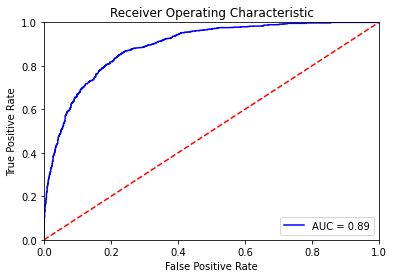

In [156]:
import sklearn.metrics as metrics
#ROC
# calculate the fpr and tpr for all thresholds of the classification
probs = random_search.predict_proba(X_test_tf)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [141]:
#Getting top 10 words that suggest trolls
best_model = random_search.best_estimator_
importance = enumerate(best_model.coef_[0])
importance = sorted(importance, key=lambda x:x[1],reverse=True)[:10]
place=1
for i,v in importance:
    print(f"{place}) Word:{count_vect.get_feature_names()[i]}, Feature: {i}, Score: {v}f")
    place+=1

1) Word:fuck, Feature: 3781, Score: -3.9302074648627077f
2) Word:hate, Feature: 4469, Score: -4.135976487295397f
3) Word:suck, Feature: 9742, Score: -4.324105509253734f
4) Word:damn, Feature: 2368, Score: -4.365193805442981f
5) Word:ass, Feature: 505, Score: -4.479410350214048f
6) Word:bitch, Feature: 1010, Score: -4.808106110483631f
7) Word:lol, Feature: 5966, Score: -4.957615723328781f
8) Word:gay, Feature: 3914, Score: -5.059007392794637f
9) Word:get, Feature: 3972, Score: -5.138625000521493f
10) Word:like, Feature: 5869, Score: -5.247939382910364f


/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)
